In [ ]:
#pip install SALib

In [1]:
import requests
#import pprint
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TVL

In [2]:
url = 'https://api.debank.com/project/tvl_chart?id=makerdao' #DeBank MakerDAO API
r = requests.get(url)
data = r.json()
data = data['data']
date = []
tvl = []
for i in range(len(data)):
    date.append(dt.datetime.strptime (data[i]['date_at'], '%Y-%m-%d'))
    tvl.append(data[i]['locked_usd_value'])
    
maker_tvl = pd.DataFrame (data = tvl, index = date, columns=["Maker"])

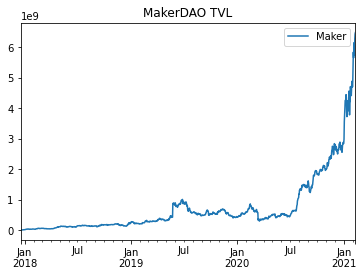

In [3]:
maker_tvl.plot(title = "MakerDAO TVL")

In [23]:
tvl_2017 = int((maker_tvl[maker_tvl.index == dt.datetime(2017, 12, 31)]).iloc[0])
tvl_2018 = int((maker_tvl[maker_tvl.index == dt.datetime(2018, 12, 31)]).iloc[0])
tvl_2019 = int((maker_tvl[maker_tvl.index == dt.datetime(2019, 12, 31)]).iloc[0])
tvl_2020 = int((maker_tvl[maker_tvl.index == dt.datetime(2020, 12, 31)]).iloc[0])
tvl_today = int(maker_tvl.iloc[-1])
tvl_year_ago = int(maker_tvl.iloc[-365])

In [28]:
ggr_2018_monthly = ((tvl_2018 / tvl_2017)**(1/12))-1
ggr_2019_monthly = ((tvl_2019 / tvl_2018)**(1/12))-1
ggr_2020_monthly = ((tvl_2020 / tvl_2019)**(1/12))-1
ggr_recent = ((tvl_today / tvl_year_ago)**(1/12))-1

ggr_2018_monthly, ggr_2019_monthly, ggr_2020_monthly, ggr_recent

(0.2334251097659763,
 0.04733058793604239,
 0.16652129769768753,
 0.19757525148813926)

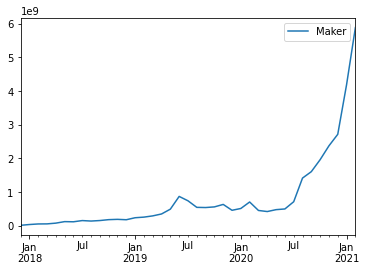

In [6]:
maker_monthly_mean_tvl = maker_tvl.groupby(pd.Grouper(freq="M")).mean()
maker_monthly_mean_tvl.plot()

# Forecast

In [30]:
geometric_growth_rate = ggr_recent
forecast_length = 48 #months
stability_fee_annual = 0.085 #https://mkr.tools/governance/stabilityfee
stability_fee_monthly = stability_fee_annual / 12
discount_rate = 0.4
monthly_discount = 0.4/12
terminal_growth = 0.1
terminal_growth_monthly = terminal_growth / 12
MKR_holders_revenue_share = 1
Total_MKR = np.ones(48)*1000000 #assuming that revenue is shared between 1M MKR holders at each point
LTV = 0.4

Next we will set the average TVL over the past 30 days as a base for estimating TVL going forward.

In [31]:
base = maker_tvl.iloc[-30:, :].mean()[0]
print (base)

4871943607.761051


In [32]:
#organizing dates (would've been easier in excel)
start = pd.to_datetime(dt.datetime.today().date())
import dateutil
date_list = [start]
for i in range(forecast_length - 1):
    date_list.append(date_list[i] + dateutil.relativedelta.relativedelta(months=+1))

In [33]:
def valuation (base = base, forecast_length = forecast_length, geometric_growth_rate = geometric_growth_rate, 
               date_list = date_list, terminal_growth_monthly = terminal_growth_monthly, discount_rate = discount_rate,
               monthly_discount = monthly_discount, stability_fee_monthly = stability_fee_monthly, 
               Total_MKR = Total_MKR, MKR_holders_revenue_share = MKR_holders_revenue_share, LTV = LTV):
    
    #setting last month in 2020 as the base for estimation
    
    base = base * LTV # to estimate amount of minted DAI
    forecast_tvl = [base]
    for i in range(forecast_length):
        forecast_tvl.append(forecast_tvl[i] + ggr_2020_monthly * forecast_tvl[i]*np.random.uniform(low=-0.5, high=1))

    forecast_tvl = forecast_tvl[1:]
    forecast = pd.DataFrame(data=forecast_tvl, index=date_list, columns=['Maker TVL Forecast'])

    forecast['Revenue'] = forecast['Maker TVL Forecast'] * stability_fee_monthly
    forecast['Profit'] = forecast['Revenue'] * MKR_holders_revenue_share

    forecast['Total Token #'] = Total_MKR
    forecast['Profit per Token'] =  forecast['Profit']  / forecast['Total Token #']
    forecast ['Periods'] = np.arange(1, 49)
    forecast['Discount Factor'] = (1+monthly_discount)**forecast['Periods']
    forecast ['Discounted Profit per Token'] = forecast['Profit per Token'] / forecast['Discount Factor']
    
    TV = forecast['Profit per Token'][-1] * (1+terminal_growth_monthly) / (monthly_discount - terminal_growth_monthly)
    TV_discounted = TV / (1+discount_rate)**4
    price_per_token = TV_discounted + forecast['Discounted Profit per Token'].sum()
    
    return price_per_token

# Monte Carlo Analysis 

In [34]:
MKR_price = []

for i in range(10000):
    MKR_price.append (valuation())

In [35]:
np.average(MKR_price), np.median(MKR_price)

(1843.744341477187, 1691.9043908419424)

In [36]:
np.max(MKR_price)

9924.292219277982

(array([1.000e+00, 1.270e+02, 6.260e+02, 1.344e+03, 1.667e+03, 1.573e+03,
        1.283e+03, 1.017e+03]),
 array([ 250,  500,  750, 1000, 1250, 1500, 1750, 2000, 2250]),
 <a list of 8 Patch objects>)

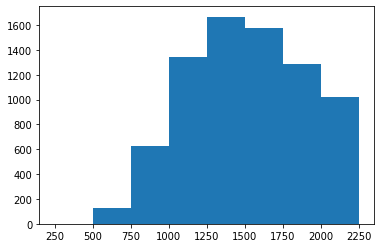

In [37]:
plt.hist(MKR_price, bins=[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250])